## Missing areas
> Make text data useful
> redo Model

> Custom DataSet creation
> Modify model to make it multi-modal

1. Load important packages and Functions

How was the text data used?

ResNet-50 architecture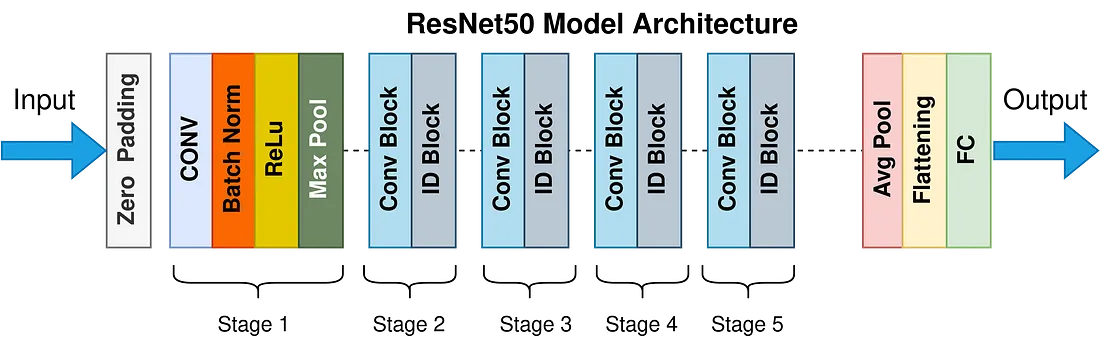

In [ ]:
#---------- Importing useful packages --------------#
import torch # pytorch main library
import glob
import torchvision # computer vision utilities
import torchvision.transforms as transforms # transforms used in the pre-processing of the data
from torchvision import *

from PIL import Image
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np


import time
import copy
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
##-----------------------------------------------------------------------------------------------------------##

In [ ]:
# set paths to retrieve data
TRAIN_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Train"
VAL_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Validation"
TEST_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Test"

In [ ]:
#--------------------- Important Functions -----------------------------------#

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))  # Assuming class folders are sorted
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)
# Trying to create a Dataset that includes the text and image data for muulti-modal classification implementation
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class MultiModalDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label2idx, transform=None):
        self.df = dataframe
        self.transform = transform
        self.label2idx = label2idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_id = self.df.loc[index, 'ImageID']
        image_path = f'{BASE_PATH}/data/{image_id}'
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = self.df.loc[index, 'Caption']
        caption_tensor = torch.zeros((MAX_CAPTION_LENGTH,), dtype=torch.long)
        caption_tokens = nltk.word_tokenize(caption.lower())
        for i, token in enumerate(caption_tokens):
            if i >= MAX_CAPTION_LENGTH:
                break
            if token in word2idx:
                caption_tensor[i] = word2idx[token]
            else:
                caption_tensor[i] = word2idx['<unk>']
        if 'Labels' in self.df.columns:
            labels = self.df.loc[index, 'Labels']
            label_tensor = torch.zeros((NUM_CLASSES,), dtype=torch.float)
            label_ids = [int(label) for label in labels.split()]
            for label_id in label_ids:
                if str(label_id) in self.label2idx:
                    label_tensor[self.label2idx[str(label_id)]] = 1
            return image, caption_tensor, label_tensor
        else:
            return image, caption_tensor

# functions to show an image
def imshow(img,stats):
    img = img *stats[1] + stats[0]     # unnormalize
    npimg = img.numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


2. Set your main hyperparameters
    - batch size
    - learning rate
    - number of epochs

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
# Set the hyperparameters
batch_size = 128 # Change Batch Size o
learning_rate = 1e-3
num_workers = 4
nepochs = 20 #"Use it to chane iterations"
best_loss = 1e+20
##-----------------------------------------------------------------------------------------------------------##


3. Data Loading and Pre-processing and Experimental setup
    -   Data already split
    -   Set data augmentation
    -   Create data loaders
    - Padded the images so they are square
    - Resized the images to a managable size

Pay attention to text labels

Use customdataset function to create a dataset with both images and text as label.

Multimodal classification as a way to merge text and image data for classification. https://www.kaggle.com/code/fabraz/image-and-text-multimodal

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
#------------ Data Loadinga and Pre-processing -------------------#
# IMAGE
# Convert the data to a PyTorch tensor

torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])])


#Dataset has been pre-split, load all data sets.
train_dataset = ImageFolder(root=TRAIN_PATH, transform= torchvision_transform)
val_dataset = ImageFolder(root=VAL_PATH, transform= torchvision_transform)
test_dataset = ImageFolder(root=TEST_PATH, transform= torchvision_transform_test)
train_set_size = int(len(train_dataset))
val_set_size = int(len(val_dataset))
test_set_size = int(len(test_dataset))

# Get the data loader for the train set
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


#classes = ('green', 'blue', 'black', 'other')
class_names = train_dataset.classes
print(class_names)
print("Train set:", train_set_size)
print("Val set:", val_set_size)
print("Test set:", test_set_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

# Pre processing for ResNet-50. Inputs and output sizes,
##-----------------------------------------------------------------------------------------------------------##

In [ ]:
# TEXT
# The file names will be extracted and used as labels


# One- Hot Encoding is used to repressent labels for easy use of categorical cross- Entropy Loss.

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


4. Transfer learning
    - SOTA models on imagenet
    - Add and train new top/predictor
    - Fine-tune all or some feature learning layers
>Setup feature extractor properly

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
#----------- Defining Model. -------------#
# ResNet-50 being used as a fixed feature extractor and the last fully connected layer will be trained

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


## Train and Eval
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)



visualize_model(model_conv)

plt.ioff()
plt.show()


##  Transfer Learning of ResNet-50
net = models.resnet18(pretrained=True)# Calling a pre-trained ResNet-50 model
net = net.cuda() if device else net
net

net.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Optimizer used for training

# Number of filters
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if use_cuda else net.fc
##-----------------------------------------------------------------------------------------------------------##

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape

        # transfer learning if weights=True
        self.feature_extractor = models.resnet18(weights=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
## Setting up Model Classifier
        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

# this gets the number of filters from the feature extractor output
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)

       return x


In [ ]:
net = GarbageModel(4, (3,224,224), True)
net.to(device)
##-----------------------------------------------------------------------------------------------------------##

5. Loss and Callbacks
    -   Loss: categorical cross-entropy
    - Using the Adam Optimizer for it's adaptaive learning rate, over SGD becaue of computational time.

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
#------- Training Parameters ---------#
# Loss Function
criterion = nn.CrossEntropyLoss() # Loss function

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001) # Optimizer used for training
#optimizer = optim.Adam(model.parameters(), lr=2e-5)# Optimizer used for training


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = ExponentialLR(optimizer, gamma=0.9)

6. Set your callbacks and track your experiments
    - Early stopping - patience
    - Model check point
    - Learning rate scheduler
    - Weights and biases (train/val loss)

In [ ]:
PATH = './garbage_net.pth' # Path to save the best model
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()

    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')

        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss

print('Finished Training')
##-----------------------------------------------------------------------------------------------------------##

8. Train
    - Train your model
    - Need to write your training code in pure Python and PyTorch or use another library like lightning or ignite

9. Test
    - Run prediction on your test set
    - Extract relevant metrics
    - Measure inference time

Metrics
- Metrics: Accuracy, F1-score, confusion matrix, training and inference time?

In [ ]:
##-----------------------------------------------------------------------------------------------------------##
#-------------- Metrics -------------#

# ACCURACY
correct = 0
total = 0

#def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()
"Check how to define Accuracy"
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


##
#plot Accuracy
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])

            if images_so_far == num_images:
                return

plt.ion()
visualize_model(net)
plt.ioff()
##-----------------------------------------------------------------------------------------------------------##


# References


1.   CNN Minst tutorial
2.   https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet
3. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
4. Multimodal https://www.kaggle.com/code/fabraz/image-and-text-multimodal

